## Introduction  

### Session purpose
In this session, we are introducing unsupervised learning (e.g., clustering analysis) using the the land cover classification example data set for Asheville.  

### Session contents
In this session, we will be covering the following topics:

1. k-means clustering;
2. hirerachical clusering;
3. clustering result evaluation;

### About the data set  
The data set is actual satellite imagery of our home city of Asheville, taken from Landsat 8, an imaging satellite that was launched in 2013.

Check out the following links for more information: https://www.usgs.gov/land-resources/nli/landsat/landsat-8?qt-science_support_page_related_con=0#qt-science_support_page_related_con

https://landsat.gsfc.nasa.gov/landsat-data-continuity-mission/ 

Before we starts to read in the data and create our first classifier, we need to load libraries that will be used in the notebook. We will heavily rely on [**caret**](https://topepo.github.io/caret/index.html) library in R for model training. *caret* is a powerful wrapper package which calls hunders of machine learning packages in R and simplify model training and application process.  

In [1]:
library(ggplot2); library(factoextra)                             # package for visualization
library(readr); library(dplyr)                                    # package for data handeling

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## 1 - Review of the data  

In this tutorial, we are still using the same dataset that we used during our previous training on land cover classification for Asheville area. Instead of going through 
each step in details, we will just do a quick review of the data.  

### 1.1 - Data ingest 

First thing first, we will read in the data for this notebook which is included in this Github repository. The data file [*NC_L8_GroundTruth.csv*](https://github.com/geo-yrao/ML4ES-tutorials/blob/master/01-Data/NC_L8_GroundTruth.csv) contains sampled pixels in western North Carolina. The data contains both the multispectral reflectance from Landsat-8 OLI data and corresponding land cover types from USGS Cropland Data Layer (CDL). We can see the first 10 lines of the data. Our data contains the location (*"Latitude","Longitude"*), land cover type (*"Class"*), and reflectance of six OLI channels (*"B1"~"B6"*). Let's first check how the data frame looks like.

In [8]:
## Here, we read in the data pairs between reflectance (scale factor: 0.0001) and land cover types
fname <- "~/ML4ES-tutorials/00-Data/NC_L8_GroundTruth.csv"
AVLData <- read.csv(fname, header=TRUE); 
head(AVLData, 10)

,X,Latitude,Longitude,Class,B1,B2,B3,B4,B5,B6
,<int>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1,35.51477,-82.68045,0,127,150,550,226,3609,1441
2,2,35.75398,-82.52043,0,81,115,426,170,2913,1110
3,3,35.71063,-82.30566,0,156,220,538,477,2492,2077
4,4,35.51281,-82.41386,0,245,280,663,507,2732,1531
5,5,35.52064,-82.85318,0,148,181,534,265,3320,1457
6,6,35.61906,-82.80788,0,202,289,651,522,3047,2251
7,7,35.55420,-82.50479,0,208,250,521,408,2905,1738
8,8,35.56040,-82.30077,0,60,91,486,184,3431,1342
9,9,35.54573,-82.50511,0,122,155,463,219,3385,1264


The following table present the information about the six [OLI chanles](https://en.wikipedia.org/wiki/Landsat_8) included in the data. 
The reflectance data can provide unique information to charaterize different land cover types.

| Channel No. | Channel Name | Wavelength |
|-:|-:|:-:|
|B1|Coastal/Areasol|0.433 – 0.453 μm| 
|B2|Blue|0.450 – 0.515 μm|
|B3|Green|0.525 – 0.600 μm|
|B4|Red|0.630 – 0.680 μm|
|B5|Near Infrared|0.845 – 0.885 μm|
|B6|Short Wavelength Infrared|1.560 – 1.660 μm|  

In our data, there are five different land cover types as listed in the table below.  

| Class No. | Land Cover Type |
|-:|-:|
|0|Forest| 
|1|Corn|
|2|Soy|
|3|Development/Urban|
|4|Water| 

Here, we create a histogram to examing the histogram of land cover types in the data.  

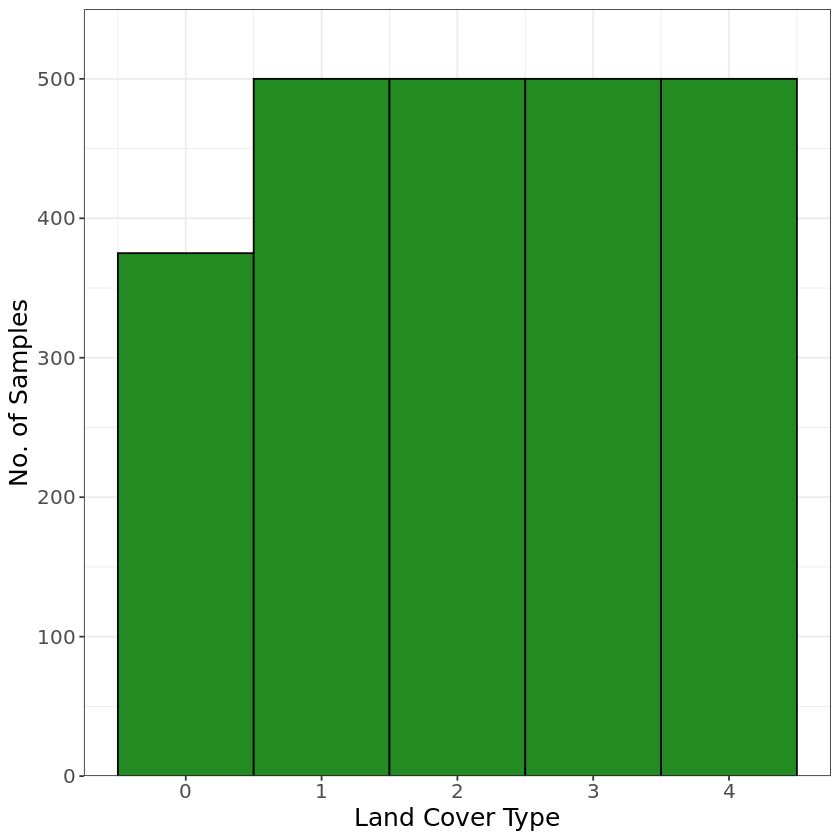

In [9]:
# Show the histogram of different land cover types using ggplot2
AVLData %>% ggplot() + geom_histogram(aes(Class), binwidth = 1, color="black", fill="forestgreen") +
  labs(x="Land Cover Type", y="No. of Samples") + coord_cartesian(ylim=c(0,550), xlim=c(-0.75,4.75), expand=F) +
  theme_bw() + theme(text=element_text(size=15))

### 1.2 - Data preprocessing 

As you can see, the data is overall well balanced across different land cover types except for forest (*Class == 0*). 

In the unsupervised learning (or clustering for this module), we usually don't have the *"Class"* information in the data set. 
We will use the features (e.g., reflectance of six spectral bands, *B1*~*B6*) to identify clusters in the data set. This can be
very useful for data exploration and identifying patterns in the data set.

Before we perform cluster analysis, let's take a quick look at the data to refresh our memory.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2



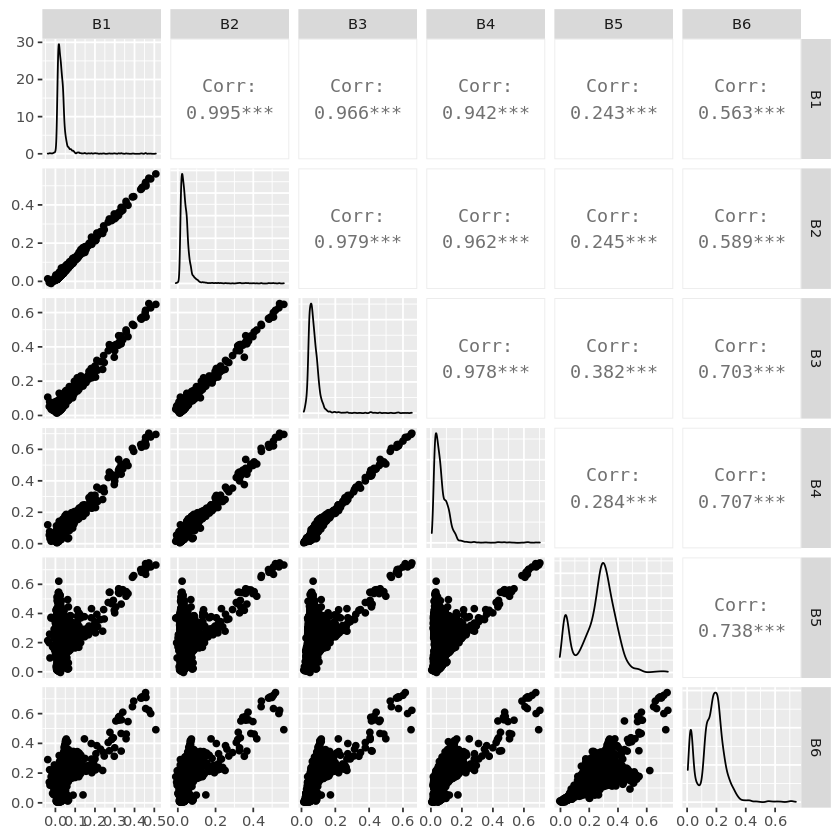

In [10]:
## We only take the reflectance data B1~B6 and scale them to 0~1 which is the real range of reflectance
rData <- (AVLData %>% dplyr::select(B1:B6))*0.0001
## generate pairwise scatter plot among six variables
GGally::ggpairs(data = rData)

The pairwise scatter plots remind us that there are strong correlation among reflectances of several channels (e.g., B1~B3). So it will likely be helpful to perform principle component analysis (PCA) or other similar analytics which will be helpfulfor further analysis.

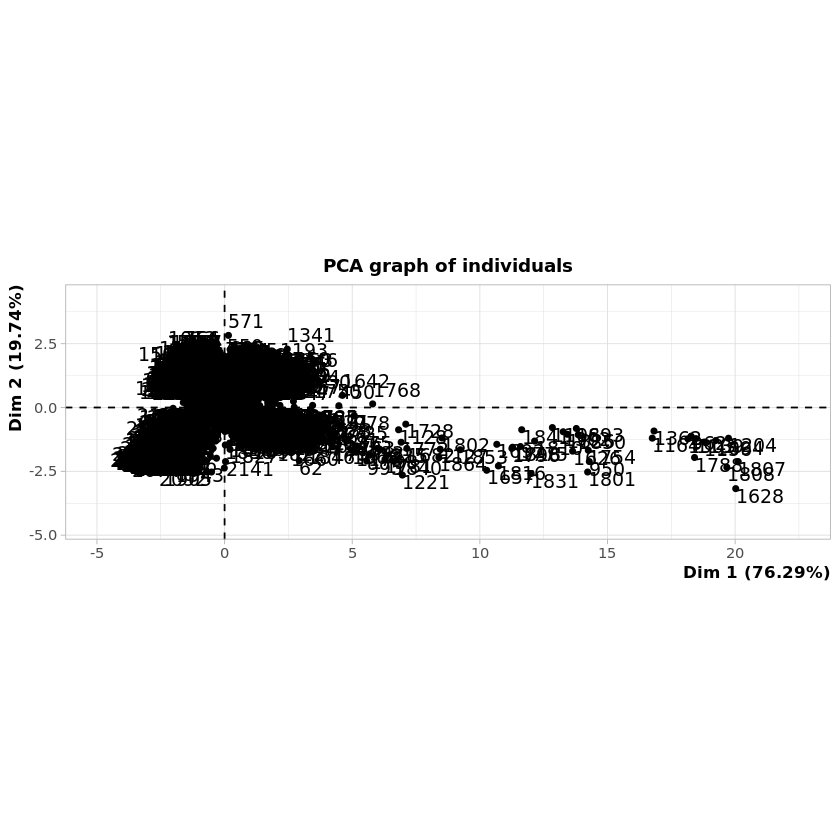

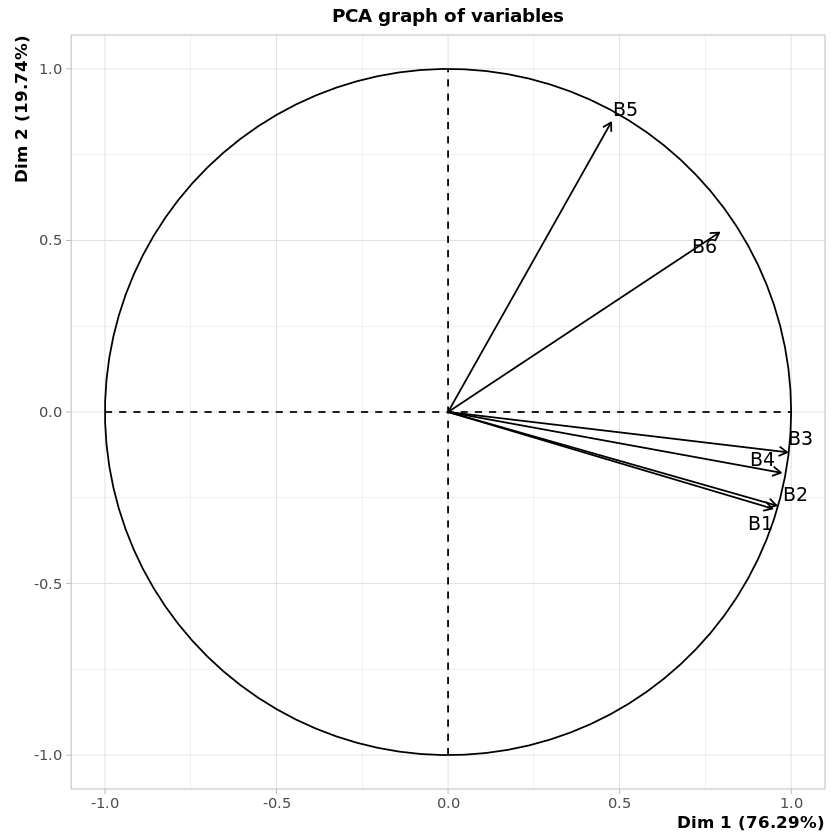

In [11]:
## Using PCA function from FactoMineR package for PCA analysis
pca_res <- FactoMineR::PCA(rData)

The PCA result show that the first three PC can explain more than 99% of the variance in the data set.


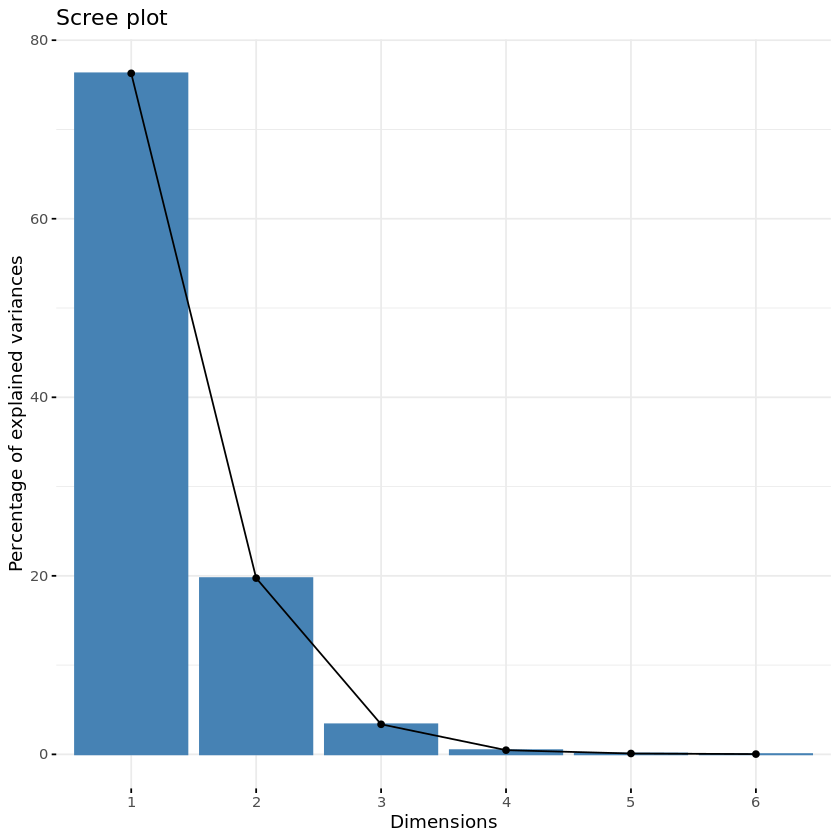

In [12]:
## plot the eigenvalue for the PCA results
fviz_eig(pca_res)

Moving forward, we will use the first three PCs for our cluster analysis. You can also try to conduct the cluster
analysis with the original data and see if the results are different.


In [13]:
## extract the pca results for the first three PCs
pcaData <- factoextra::get_pca_ind(pca_res)$coord[,1:3]
str(pcaData)

 num [1:2375, 1:3] -0.898 -1.366 -0.596 -0.511 -0.882 ...
 - attr(*, "dimnames")=List of 2
  ..$ : chr [1:2375] "1" "2" "3" "4" ...
  ..$ : chr [1:3] "Dim.1" "Dim.2" "Dim.3"


## 2 - K-means Clustering

In [14]:
## Since we already knew there are five classes in this data, so let's try if we can
## generate a 5-cluster result through K-means
set.seed(2021) ## setting seed number to maximize reproducibility
kcluster <- kmeans(pcaData, centers=5, nstart = 10)
kcluster

K-means clustering with 5 clusters of sizes 30, 507, 696, 1097, 45

Cluster means:
       Dim.1      Dim.2      Dim.3
1 14.9865962 -1.5827153  0.9897679
2 -1.4541863 -1.6121763  0.0915311
3  0.8892873  0.1098490 -0.4665965
4 -0.5067990  0.7650922  0.2137911
5  4.9930936 -1.1312494  0.3138442

Clustering vector:
   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
   4    4    4    4    4    4    4    4    4    4    4    4    4    4    4    4 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
   4    4    4    4    4    4    4    4    4    4    4    4    4    4    4    4 
  33   34   35   36   37   38   39   40   41   42   43   44   45   46   47   48 
   4    4    4    4    4    4    4    4    4    4    4    2    4    4    4    4 
  49   50   51   52   53   54   55   56   57   58   59   60   61   62   63   64 
   4    4    2    4    4    4    4    4    4    4    4    4    4    5    4    4 
  65   66   67   68   69   70   71   72

With the K-Means, it will always generate clusterign results after you define how many clusters we are expecting (i.e., k). Now, let's see how the clustering result look like in the feature space.

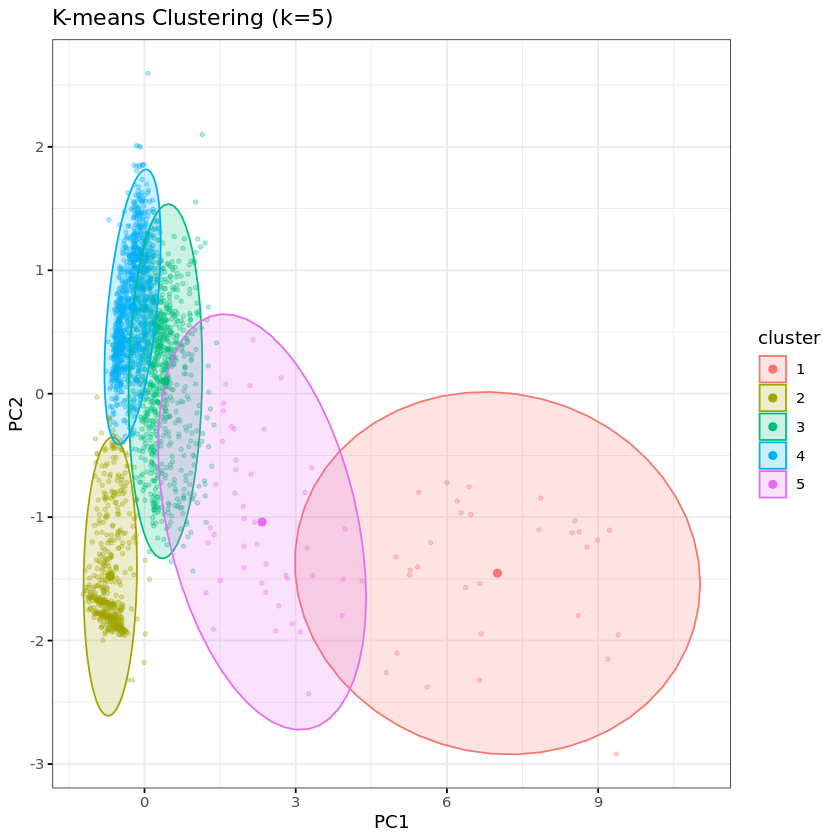

In [15]:
## using fviz_cluster from package factoextra for visuazlization using the first 2 PCs.
factoextra::fviz_cluster(kcluster, data = pcaData, choose.vars = c("Dim.1", "Dim.2"),
                         show.clust.cent = TRUE, ## showing the centorid of each cluster
                         shape = 20, main = "K-means Clustering (k=5)", 
                         geom = c("point"), xlab = "PC1", ylab = "PC2", alpha=0.3, 
                         ## We can also add a ellipse around each cluster to see how it performs
                         ellipse.type = "norm", ggtheme = theme_bw())

The clustering analysis result seems reasonable. But how can we evaluate the performance of the clustering results
quantitatively? Here comes the Silhouette analysis.  

  cluster size ave.sil.width
1       1   30          0.55
2       2  507          0.65
3       3  696          0.33
4       4 1097          0.47
5       5   45          0.39


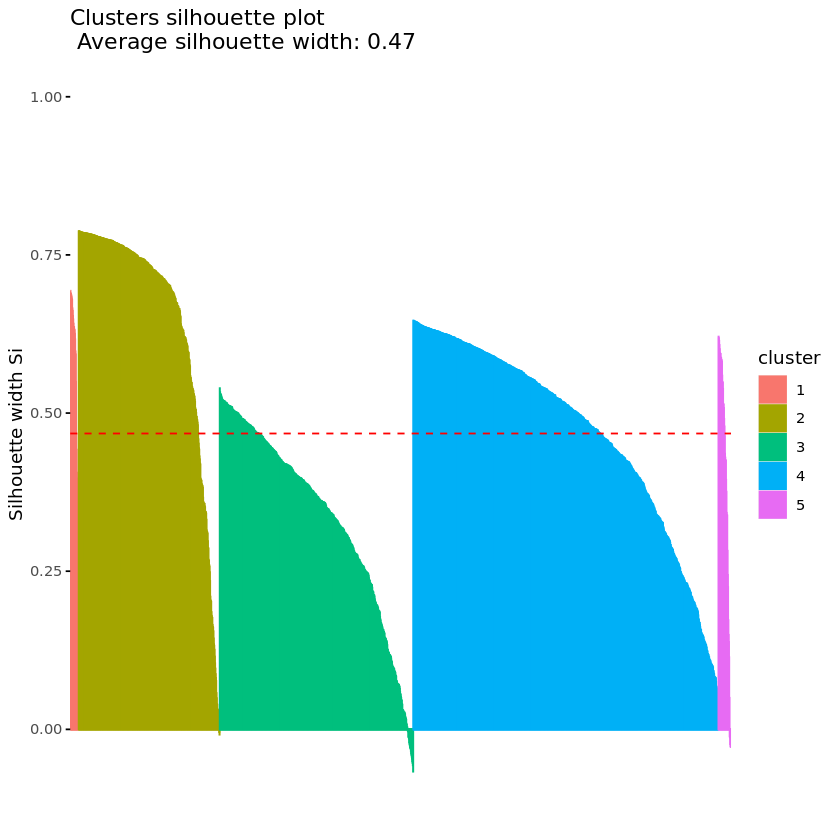

In [16]:
## calculate silhoutte score using cluster package which also require the 
## distance/dissimilarity matrix using function of dist()
sil_kmeans <- cluster::silhouette(kcluster$cluster, dist(pcaData))

## and we can visualize the Silhouette score for the clustering results
factoextra::fviz_silhouette(sil_kmeans, print.summary = TRUE)

It appears that the second cluster is more compact than the remaining clusters. So how does this result compare with our know land cover types? We can cross-tabulate these two type of lables to see if there are strong association between the two.

In [17]:
## use table() function to compare two labels
table(AVLData$Class, kcluster$cluster, 
      ## dimension names
      dnn = c("Land cover types", "k-Means Clustering"))

                k-Means Clustering
Land cover types   1   2   3   4   5
               0   0  22   9 343   1
               1   0   2 204 291   3
               2  11   0 266 217   6
               3  19  16 209 221  35
               4   0 467   8  25   0

As K-Means require the "k" to be specified for clustering analysis, how can we define a k value that is "optimal"?
There are several ways to examine this question by looking at the similarities within each cluster and dissimilarities
across different clusters. Let's just use Silhouetee scores again to decide such optimal number of clusters.

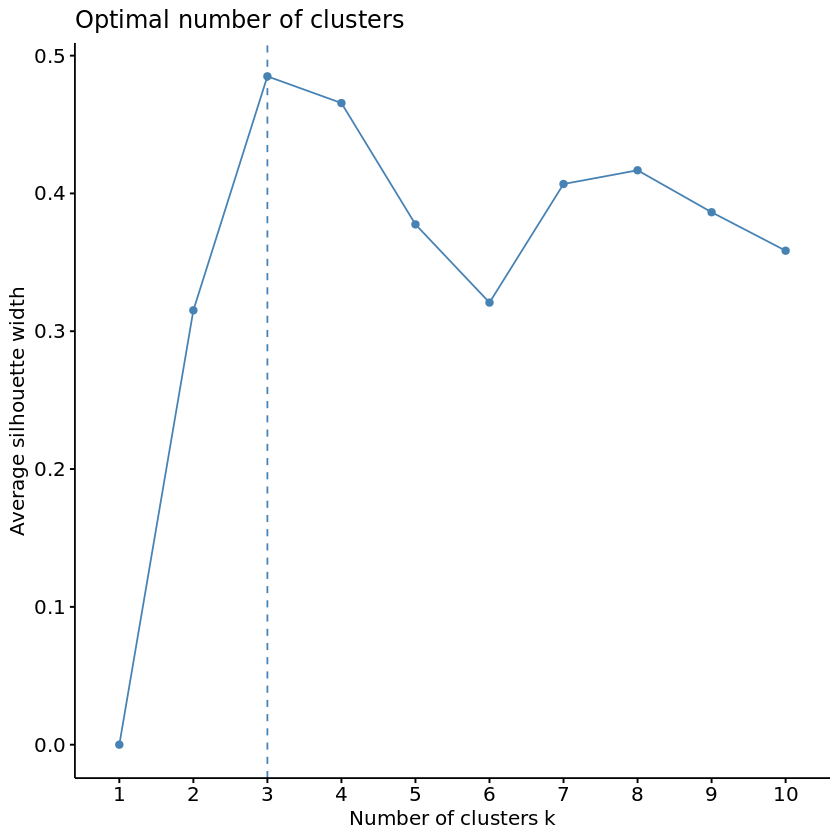

In [18]:
## we can use fviz_nbclust() function from factoextra to show the optimal number of clusters
set.seed(2021) ## set seed number to maximize reproducibility
factoextra::fviz_nbclust(pcaData, kmeans, method = "silhouette")

As we can see, this analysis perform clustering analysis for different k-values and calculate the Silhouette score for 
each k values and compare the results. It appears that k=3 yields the best clustering results with best separation. So
let's try the clustering with k = 3 for the "optimal" clustering.

  cluster size ave.sil.width
1       1   40          0.55
2       2  517          0.67
3       3 1818          0.43


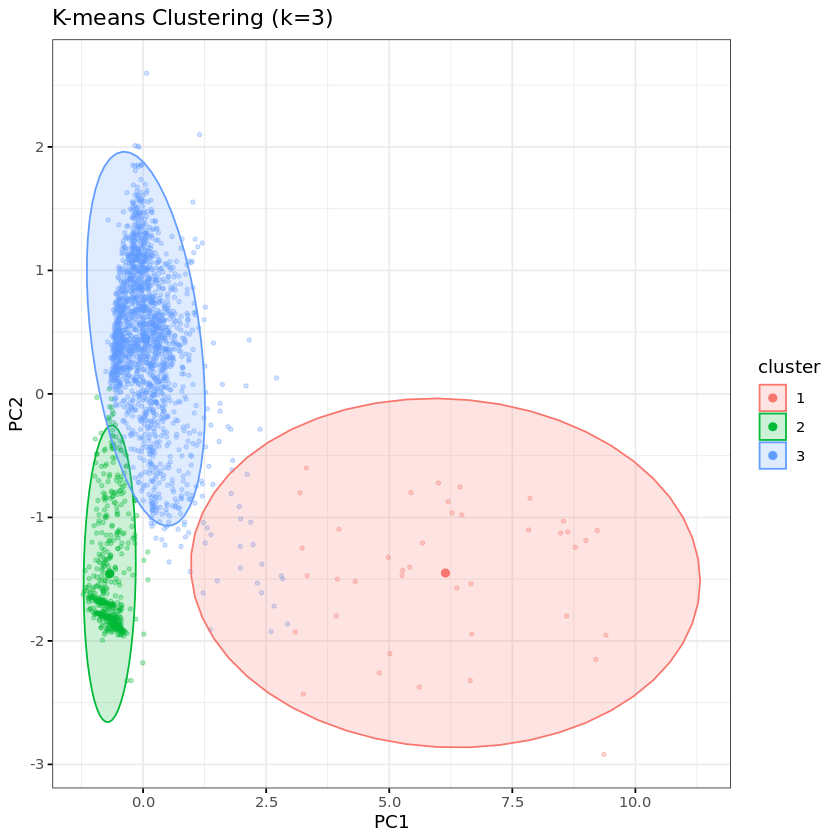

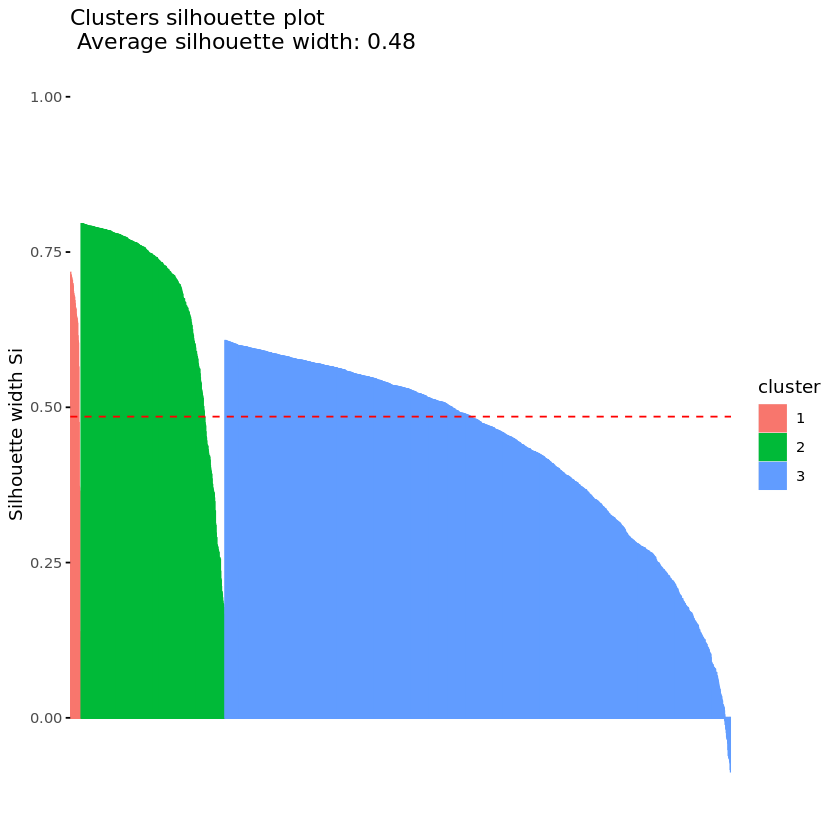

In [19]:
## optimal kmeans clustering with three clusters
set.seed(2021)
kcluster_opt <- kmeans(pcaData, centers = 3, nstart = 10)

## generate the cluster plot
factoextra::fviz_cluster(kcluster_opt, data = pcaData, choose.vars = c("Dim.1", "Dim.2"),
                         show.clust.cent = TRUE, ## showing the centorid of each cluster
                         shape = 20, main = "K-means Clustering (k=3)", 
                         geom = c("point"), xlab = "PC1", ylab = "PC2", alpha=0.3, 
                         ## We can also add a ellipse around each cluster to see how it performs
                         ellipse.type = "norm", ggtheme = theme_bw())

## and we can visualize the Silhouette score for the clustering results
sil_kmeans_opt <- cluster::silhouette(kcluster_opt$cluster, dist(pcaData))
factoextra::fviz_silhouette(sil_kmeans_opt, print.summary = TRUE)


## 3 - Hierachical clustering

In [20]:
### We can perform the hirerachical clustering using the optimal number of clusters of 3
hcluster <- hcut(pcaData, k=3, hc_method = "ward.D2")

In [ ]:
### let's visualize the dendrogram
fviz_dend(hcluster, show_labels = FALSE, 
          ## show the rectangel for each cluster
          rect = TRUE)

The dendrogram is quite intutitive to show how the hirerachical clustering are achieved by cutting the "tree"
at certain level. It can be decided either by choosing the number of clusters that we want or the value of 
height where we want the process to stop. Now let's see how the cluster is determined.

  cluster size ave.sil.width
1       1 1857          0.41
2       2  488          0.71
3       3   30          0.71


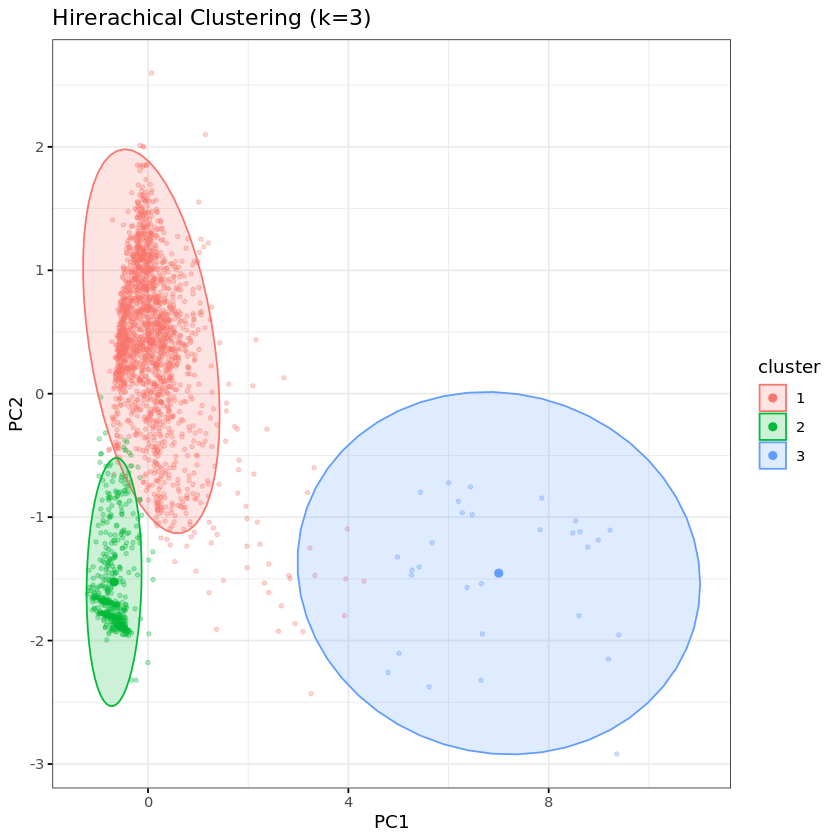

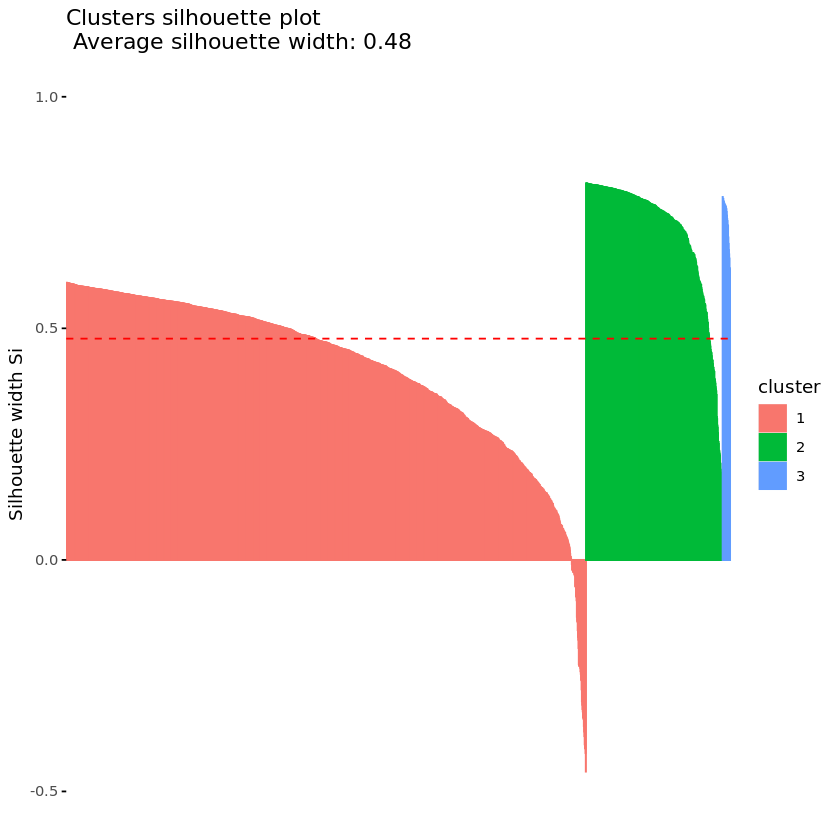

In [21]:
## visualize clustering results
factoextra::fviz_cluster(hcluster, data = pcaData, choose.vars = c("Dim.1", "Dim.2"),
                         show.clust.cent = TRUE, ## showing the centorid of each cluster
                         shape = 20, main = "Hirerachical Clustering (k=3)", 
                         geom = c("point"), xlab = "PC1", ylab = "PC2", alpha=0.3, 
                         ## We can also add a ellipse around each cluster to see how it performs
                         ellipse.type = "norm", ggtheme = theme_bw())

## and we can visualize the Silhouette score for the clustering results
sil_hclust_opt <- cluster::silhouette(hcluster$cluster, dist(pcaData))
factoextra::fviz_silhouette(sil_hclust_opt, print.summary = TRUE)

Overall, the three clusters look similar with the K-Means cluster results. It should be noted that the cluster
labels are different between two clustering methods since the cluster labels do not have a specific meaning like
the land cover types. So it is just a categorical indicator.

How can we compare the two clustering results? We can always cross-tabulate the two cluster results and see how 
the cluster labels compare.

In [23]:
## cross tabulating the clusterign results between k-means and hirerachical
table(kcluster_opt$cluster, hcluster$cluster,
      dnn = c("k-means clustering", "hirerachical clustering"))


                  hirerachical clustering
k-means clustering    1    2    3
                 1   10    0   30
                 2   31  486    0
                 3 1816    2    0

From this table, it looks like that we have two sets of similar clustering results. But there are some differences 
for the clustering results. Can we quantify the similarity between to clustering analysis results? The answer is yes!

There are several indicators that can be used to compare the cluster reuslts, such as (adjusted) rand index, (adjusted)
mutual information and more. We can calculate such index using the library **aricode**.

In [24]:
print("========= Adjusted Rand Index =========")
aricode::ARI(kcluster_opt$cluster, hcluster$cluster)
print("========= Adjusted Mutual Information =========")
aricode::AMI(kcluster_opt$cluster, hcluster$cluster)

[1] "========= Adjusted Rand Index ========="


[1] 0.9267872

[1] "========= Adjusted Mutual Information ========="


[1] 0.8381574

Both indices has a range of 0~1 and the higher the number is the more similar two sets of the clustering results are.

## 4 - Exercise

### 4.1 - Assessing the cluster results against the class labels

Although it is not common to evaluate a cluster result with ground truth labels, it is still possible and may be done occasionally.
So can you try to compare the clustering results and the class label come with the data?

You can first try to cross tabulate the two sets of labels and then try to calculate the indicators (e.g., adjusted rand index,
adjusted mutual information).

In [25]:
### cross tabulate labels between k-means and class labels

### cross tabulate labels between hirerachical and class labels

### calculate the indicators between k-means and class labels

### calculate the indicators between hirerachical and class labels


### 4.2 - evaluate the impact of number of clusters for hirerachical clustering

In the notebook, we only use the k = 3 to perform the hirerachical clustering, but with the dendrogram plot, we can
easily manupulate how many clusters we want to cut the "tree". So try to explore the clustering results with different
number of clusters and evaluate the clustering results with k-means clustering and clustering results with different
cluster numbers.